In [32]:
DEBUG = False
CONFIG_FILE = '/datascope/subaru/data/targeting/MW/outerdisk_l180_b22_ENG/netflow/outerdisk_l180_b22_bright_002/ga-netflow_20250121223403.config'
OUTPUT_PATH = '/datascope/subaru/data/targeting/MW/outerdisk_l180_b22_ENG/netflow/outerdisk_l180_b22_bright_002'

# Plot the assigned targets

Load the data and plot the assigned targets for each pointing and visit.

In [33]:
import os, sys
from glob import glob
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [34]:
plt.rc('font', size=6)

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
if DEBUG and 'debug' not in globals():
    import debugpy
    debugpy.listen(('0.0.0.0', int(os.environ['PFS_TARGETING_DEBUGPORT'])))
    debug = True

# Imports

In [37]:
import pfs.utils
from pfs.datamodel import TargetType

from pfs.ga.targeting.config import NetflowConfig
from pfs.ga.targeting.scripts.netflow.netflowscript import NetflowScript
from pfs.ga.targeting.io import DataFrameSerializer, ObservationSerializer
from pfs.ga.targeting.targets.dsph import *
from pfs.ga.targeting.instrument import *
from pfs.ga.targeting.diagram import CMD, CCD, FOV, FP, ColorAxis, MagnitudeAxis
from pfs.ga.targeting.photometry import Photometry, Magnitude, Color
from pfs.ga.targeting.projection import WcsProjection, Pointing
from pfs.ga.targeting.netflow import Netflow
from pfs.ga.targeting.io import DataFrameSerializer

# Load the netflow config file

In [38]:
# Load the configuration
config = NetflowConfig.default()
config.load(CONFIG_FILE, ignore_collisions=True, format='.json')

print(config.targets.keys())

2025-01-21T18:02:31.778 30 cobraCoach setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-01-21T18:02:31.838 30 cobraCoach setting bad cobras: [47, 50, 173, 193, 344, 347, 361, 443, 493, 648, 738, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1303, 1460, 1494, 1520, 1539, 1580, 1637, 1653, 1724, 1790, 1791, 1792, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-01-21T18:02:31.854 20 cobraCoach cc connecting to fpga....
2025-01-21T18:02:31.862 30 butler     newRun: /tmp/cobra_coach/20250121_077


dict_keys(['gaia', 'ps1', 'sky', 'fluxstd'])


# Load the target lists

In [39]:
target_lists = {}

for key in config.targets:
    fn = os.path.join(OUTPUT_PATH, f'{config.field.key}_targets_{key}.feather')
    target_lists[key] = NetflowScript.load_target_list(key, config.targets[key], fn)
    print(key, config.targets[key].prefix, config.targets[key].path)

gaia sci $PFS_TARGETING_DATA/data/targeting/MW/outerdisk_l180_b22_ENG/ga_targets_outerdisk_l180_b22_ENG_bright-v2.csv
ps1 sci $PFS_TARGETING_DATA/data/targeting/MW/outerdisk_l180_b22_ENG/ga_targets_outerdisk_l180_b22_ENG_bright-v2.csv


2025-01-21T18:02:36.812 30 targeting  Extinction correction is not available in catalog `fluxstd` for magnitude `g`.


sky sky $PFS_TARGETING_DATA/data/targeting/MW/outerdisk_l180_b22_ENG/outerdisk_b22_sky.feather
fluxstd cal $PFS_TARGETING_DATA/data/targeting/MW/outerdisk_l180_b22_ENG/outerdisk_b22_fluxstd.feather


In [40]:
# List available photometry for each target list
for k, target_list in target_lists.items():
    print(k)
    for p in target_list.photometry:
        print(' ', p)
        for m in target_list.photometry[p].magnitudes:
            print('    ', m)

gaia
  gaia
     g
ps1
  ps1
     g
sky
fluxstd
  ps1
     g
     r
     i
     z
     y


# Load the assignments

In [41]:
# Load the assignments

fn = os.path.join(OUTPUT_PATH, f'{config.field.key}_assignments.feather')
assignments = DataFrameSerializer().read(fn)

print(assignments.shape)
for c in assignments.columns:
    print(c, assignments[c].dtype)

(2458, 26)
fiberid int32
targetid int64
pointing_idx int32
visit_idx int32
cobraid int32
sciencefiberid int32
fieldid int32
fiberholeid int32
spectrographid int32
fp_x float64
fp_y float64
target_type int32
fiber_status int32
RA float64
Dec float64
pm float64
pmra float64
pmdec float64
parallax float64
penalty Int32
prefix string
exp_time float64
priority Int32
class string
done_visits Int64
req_visits Int64


In [42]:
# Print the unique pointing and visit indices
assignments['pointing_idx'].unique(), assignments['visit_idx'].unique()

(array([0], dtype=int32), array([0], dtype=int32))

In [43]:
# Load the assignment summary

fn = os.path.join(OUTPUT_PATH, f'{config.field.key}_summary.feather')
summary = DataFrameSerializer().read(fn)

print(summary.shape)
for c in assignments.columns:
    print(c, assignments[c].dtype)

(31274, 15)
fiberid int32
targetid int64
pointing_idx int32
visit_idx int32
cobraid int32
sciencefiberid int32
fieldid int32
fiberholeid int32
spectrographid int32
fp_x float64
fp_y float64
target_type int32
fiber_status int32
RA float64
Dec float64
pm float64
pmra float64
pmdec float64
parallax float64
penalty Int32
prefix string
exp_time float64
priority Int32
class string
done_visits Int64
req_visits Int64


# Plot assigned targets

In [44]:
pfi = SubaruPFI(instrument_options=config.instrument_options)

2025-01-21T18:02:45.851 30 cobraCoach setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-01-21T18:02:45.935 30 cobraCoach setting bad cobras: [47, 50, 173, 193, 344, 347, 361, 443, 493, 648, 738, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1303, 1460, 1494, 1520, 1539, 1580, 1637, 1653, 1724, 1790, 1791, 1792, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-01-21T18:02:45.945 20 cobraCoach cc connecting to fpga....
2025-01-21T18:02:45.952 30 butler     newRun: /tmp/cobra_coach/20250121_078


In [45]:
def get_photometry_all():
    # Get unique photometric systems from all target lists
    photometry = {}
    for k, target_list in target_lists.items():
        for p, phot in target_list.photometry.items():
            if p not in photometry and len(phot.magnitudes) > 1:
                    photometry[p] = phot

    return photometry

def create_fov(pointing):
    wcs = WcsProjection(pointing, proj='TAN')
    wfc = SubaruWFC(pointing)
    fov = FOV(projection=wcs)

    return wcs, fov

def create_cmd(photometry):
    # Create a color-magnitude diagram using the first two filters of the photometric systems
    cmd = {}
    for p, phot in photometry.items():
        if len(phot.magnitudes) > 1:
            mm = list(phot.magnitudes.keys())
            m1, m2 = phot.magnitudes[mm[0]], phot.magnitudes[mm[1]]
            cmd[p] = CMD([ColorAxis(Color([m1, m2])), MagnitudeAxis(m2)])
    return cmd

def plot_assignments(f, gs, cmd, target_lists,
                     pointing, pointing_idx=None, visit_idx=None,
                     plot_background=False, plot_all=True, plot_assigned=False, plot_unassigned=False,
                     title=None):
    
    cmap = plt.get_cmap('tab10')

    # Create the field-of-view plot
    wcs, fov = create_fov(pointing)

    # Create subplots
    axs = [ f.add_subplot(gs[0], projection=wcs.wcs) ]
    for i, c in enumerate(cmd):
        axs.append(f.add_subplot(gs[i + 1]))

    # Filter for the current visit
    mask = ((pointing_idx is None) | (assignments['pointing_idx'] == pointing_idx)) \
         & ((visit_idx is None) | (assignments['visit_idx'] == visit_idx))

    unique_targets = assignments['targetid'][mask].unique()
    # print(unique_targets.shape)

    # Plot the full list of science targets in the background in grey
    for j, (k, target_list) in enumerate(target_lists.items()):
        if config.targets[k].prefix == 'sci':
            for i in range(4):
                if i == 0 and plot_background:
                    mask = None
                    color = 'grey'
                    alpha = 0.3
                    scalex, scaley = False, False
                elif i == 0:
                    continue

                if i == 1 and plot_all:
                    mask = None
                    color = cmap(j)
                    alpha = 1.0
                    scalex, scaley = True, True
                elif i == 1:
                    continue

                if i == 2 and plot_assigned:
                    mask = target_list.data['targetid'].isin(unique_targets)
                    color = cmap(j)
                    alpha = 1.0
                    scalex, scaley = True, True
                elif i == 2:
                    continue

                if i == 3 and plot_unassigned:
                    mask = ~target_list.data['targetid'].isin(unique_targets)
                    color = cmap(j)
                    alpha = 1.0
                    scalex, scaley = True, True
                elif i == 3:
                    continue

                fov.plot_catalog(axs[0], target_list, mask=mask, observed=True, color=color, alpha=alpha, size=1,
                                 scalex=scalex, scaley=scaley)

                for i, (_, c) in enumerate(cmd.items()):
                    if target_list.has_diagram_values(c, observed=True):
                        c.plot_catalog(axs[i + 1], target_list, mask=mask, observed=True, color=color, alpha=alpha, size=1)

        # if target_list.has_diagram_values(ccd, observed=True):
        #     ccd.plot_catalog(axs[1], target_list, observed=True, color='grey', alpha=1.0)

    # ax.set_title(target_list.name)
    axs[0].set_aspect('equal', adjustable='datalim')
    axs[0].legend(loc='upper right', fontsize=6)

    for i, (c, _) in enumerate(cmd.items()):
        axs[i + 1].set_title(c)

2025-01-21T18:02:48.551 30 targeting  Extinction correction is not available in catalog `gaia` for magnitude `g`.
2025-01-21T18:02:48.554 30 targeting  Extinction correction is not available in catalog `gaia` for magnitude `r`.
2025-01-21T18:02:48.556 30 targeting  Extinction correction is not available in catalog `gaia` for magnitude `r`.
2025-01-21T18:02:48.566 30 targeting  Extinction correction is not available in catalog `ps1` for magnitude `g`.
2025-01-21T18:02:48.568 30 targeting  Extinction correction is not available in catalog `ps1` for magnitude `r`.
2025-01-21T18:02:48.570 30 targeting  Extinction correction is not available in catalog `ps1` for magnitude `r`.
/tmp/ipykernel_1268488/3604770646.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(loc='upper right', fontsize=6)
2025-01-21T18:02:48.618 30 targeting  Extinction correction i

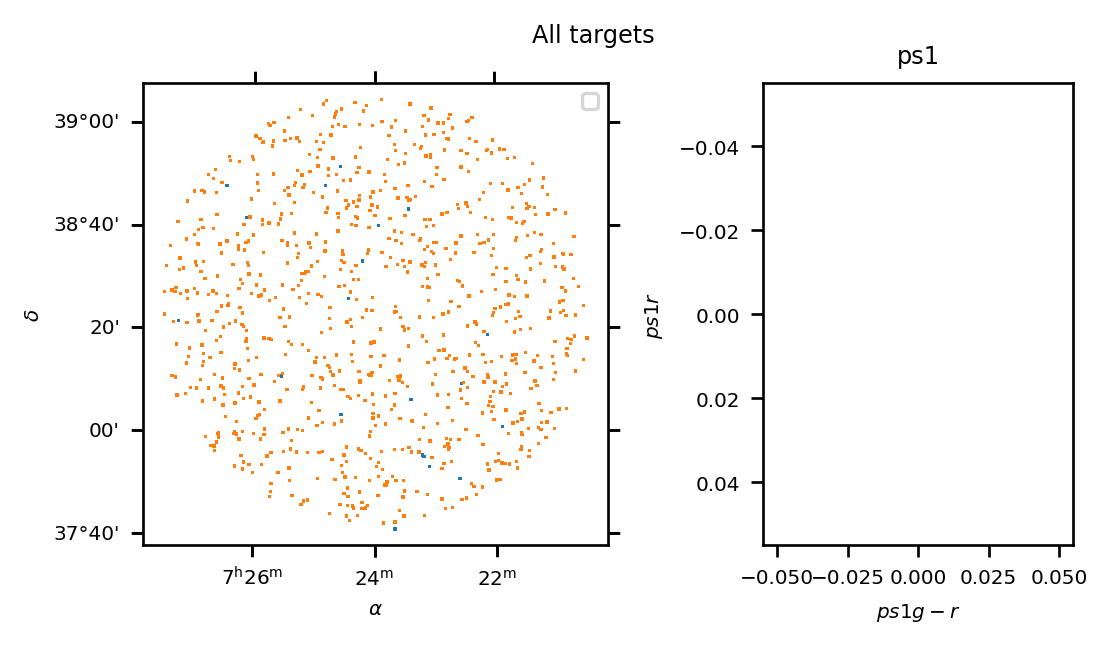

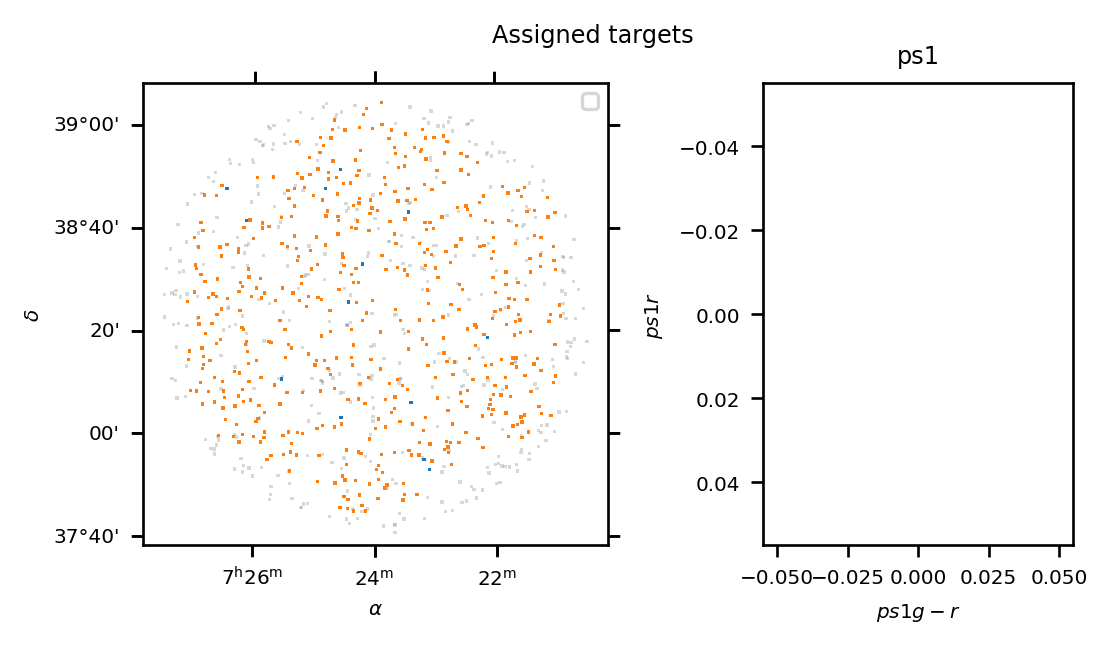

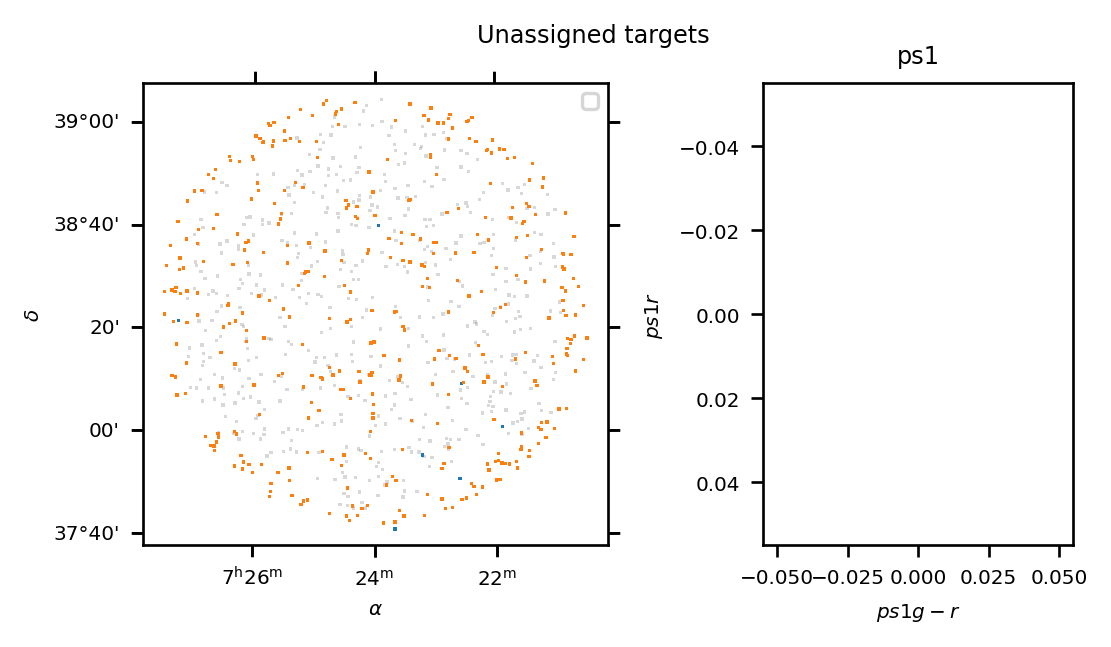

In [46]:
# Collect all photometric systems and create the corresponding CMDs
photometry = get_photometry_all()
cmd = create_cmd(photometry)

f = plt.figure(figsize=(3 + 2 * len(cmd), 2.5), dpi=240)
f.suptitle('All targets')
gs = f.add_gridspec(1, len(cmd) + 1, width_ratios=[3,] + len(cmd) * [2,], wspace=0.4, hspace=0.2)
plot_assignments(f, gs, cmd, target_lists,
                 config.pointings[0].get_pointing(),
                 plot_background=False, plot_all=True, plot_assigned=False, plot_unassigned=False)

f = plt.figure(figsize=(3 + 2 * len(cmd), 2.5), dpi=240)
f.suptitle('Assigned targets')
gs = f.add_gridspec(1, len(cmd) + 1, width_ratios=[3,] + len(cmd) * [2,], wspace=0.4, hspace=0.2)

plot_assignments(f, gs, cmd, target_lists,
                 config.pointings[0].get_pointing(),
                 plot_background=True, plot_all=False, plot_assigned=True, plot_unassigned=False)

f = plt.figure(figsize=(3 + 2 * len(cmd), 2.5), dpi=240)
f.suptitle('Unassigned targets')
gs = f.add_gridspec(1, len(cmd) + 1, width_ratios=[3,] + len(cmd) * [2,], wspace=0.4, hspace=0.2)

plot_assignments(f, gs, cmd, target_lists,
                 config.pointings[0].get_pointing(),
                 plot_background=True, plot_all=False, plot_assigned=False, plot_unassigned=True)

# Plot science targets per priority

In [47]:
#####

# Calculate statistics

In [48]:
# Total number of unique science targets observed
assignments[assignments['prefix'] == 'sci']['targetid'].nunique()

508

In [49]:
# Targets that are partially observed
summary[(summary['num_visits'] < summary['req_visits']) & (summary['num_visits'] > 0)]

,targetid,RA,Dec,pm,pmra,pmdec,parallax,penalty,prefix,exp_time,priority,class,done_visits,req_visits,num_visits


In [50]:
# Science targets that are observed longer than the required number of visits
summary[(summary['prefix'] == 'sci') & (summary['num_visits'] > summary['req_visits'])]

,targetid,RA,Dec,pm,pmra,pmdec,parallax,penalty,prefix,exp_time,priority,class,done_visits,req_visits,num_visits


In [51]:
# Number of unique targets per priority class
summary[summary['num_visits'] > 0].groupby('class')['targetid'].nunique()

class
cal       128
sci_P0      9
sci_P1      4
sci_P3    124
sci_P5    371
sky       302
Name: targetid, dtype: int64

In [52]:
# Number of missed science targets per priority class
summary[(summary['prefix'] == 'sci') & (summary['num_visits'] == 0)].groupby('class')['targetid'].nunique()

class
sci_P0      6
sci_P1      1
sci_P3     70
sci_P5    322
Name: targetid, dtype: int64

In [53]:
# Number of partially observed science targets per priority class
summary[(summary['prefix'] == 'sci') & 
        (summary['num_visits'] < summary['req_visits']) & 
        (summary['num_visits'] > 0)].groupby('class')['targetid'].nunique()

Series([], Name: targetid, dtype: int64)

In [54]:
# Number of unassigned fibers in each visit
assignments[assignments['target_type'] == TargetType.UNASSIGNED].groupby('visit_idx')['fiberid'].nunique()

visit_idx
0    1456
Name: fiberid, dtype: int64

In [55]:
# Number of unique calibration targets for each visit
assignments[assignments['prefix'] == 'cal'].groupby('visit_idx')['targetid'].nunique()

visit_idx
0    128
Name: targetid, dtype: int64

In [56]:
# Number of unique sky positions for each visit
assignments[assignments['prefix'] == 'sky'].groupby('visit_idx')['targetid'].nunique()

visit_idx
0    302
Name: targetid, dtype: int64

In [57]:
# Number of observed unique science targets for each visit
assignments[assignments['prefix'] == 'sci'].groupby('visit_idx')['targetid'].nunique()

visit_idx
0    508
Name: targetid, dtype: int64

In [58]:
# of unique science targets assigned
for pidx in np.sort(assignments['pointing_idx'].unique()):
    for vidx in np.sort(assignments[assignments['pointing_idx'] == pidx]['visit_idx'].unique()):
        mask = (assignments['visit_idx'] == vidx) & \
               (assignments['pointing_idx'] == pidx) & \
               (assignments['prefix'] == 'sci')
        print(f'Pointing #{pidx}, Visit #{vidx}:', assignments[mask]['targetid'].nunique())

print('Grand Total:', assignments[assignments['prefix'] == 'sci']['targetid'].nunique())

Pointing #0, Visit #0: 508
Grand Total: 508


In [59]:
# total # of sky fibers assigned
for pidx in np.sort(assignments['pointing_idx'].unique()):
    for vidx in np.sort(assignments[assignments['pointing_idx'] == pidx]['visit_idx'].unique()):
        mask = (assignments['visit_idx'] == vidx) & \
               (assignments['pointing_idx'] == pidx) & \
               (assignments['prefix'] == 'sky')
        print(f'Pointing #{pidx}, Visit #{vidx}:', assignments[mask]['targetid'].nunique())

print('Grand Total:', assignments[assignments['prefix'] == 'sky']['targetid'].nunique())

Pointing #0, Visit #0: 302
Grand Total: 302


In [60]:
# total # of calibration fibers assigned
for pidx in np.sort(assignments['pointing_idx'].unique()):
    for vidx in np.sort(assignments[assignments['pointing_idx'] == pidx]['visit_idx'].unique()):
        mask = (assignments['visit_idx'] == vidx) & \
               (assignments['pointing_idx'] == pidx) & \
               (assignments['prefix'] == 'cal')
        print(f'Pointing #{pidx}, Visit #{vidx}:', assignments[mask]['targetid'].nunique())

print('Grand Total:', assignments[assignments['prefix'] == 'cal']['targetid'].nunique())

Pointing #0, Visit #0: 128
Grand Total: 128


# Plot the distribution of assigned targets

gaia all [15  5]
gaia assigned [9 4]
ps1 all [  0   0   0 194   0 693]
ps1 assigned [  0   0   0 124   0 371]


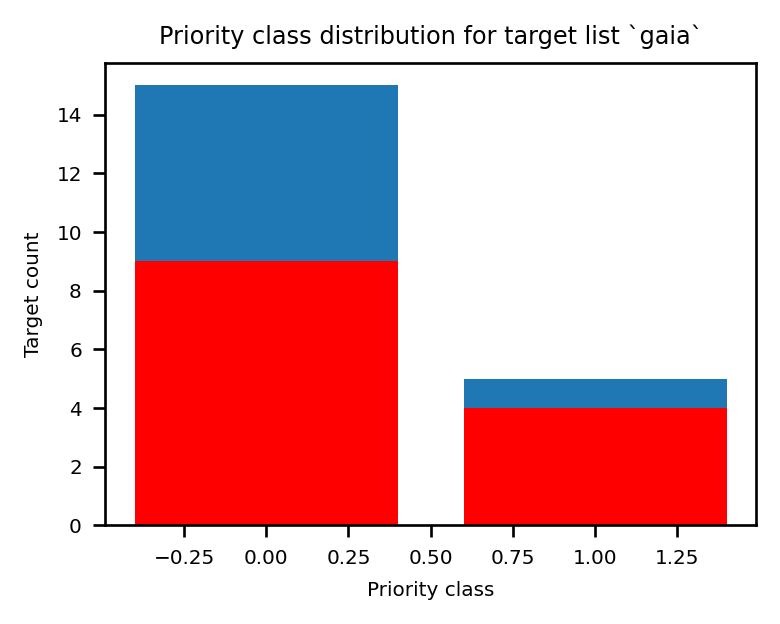

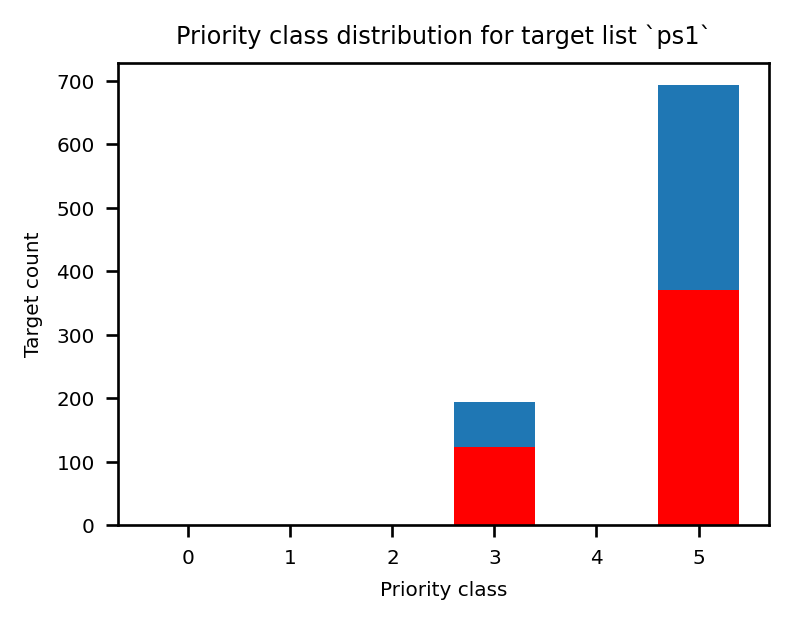

In [61]:
# Plot priority distribution for each target list
for k in config.targets:
    if config.targets[k].prefix in ['sci']:
        f, ax = plt.subplots(1, 1, figsize=(3.5, 2.5), dpi=240)

        hist = np.bincount(target_lists[k].data['priority'])
        ax.bar(np.arange(hist.size), hist)

        print(k, 'all', hist)

        mask = target_lists[k].data['targetid'].isin(assignments[assignments['prefix'] == config.targets[k].prefix]['targetid'])
        hist = np.bincount(target_lists[k].data['priority'][mask])
        ax.bar(np.arange(hist.size), hist, color='r')

        print(k, 'assigned', hist)

        ax.set_title(f'Priority class distribution for target list `{k}`')
        ax.set_xlabel(f'Priority class')
        ax.set_ylabel(f'Target count')

gaia all [ 0 20]
gaia assigned [ 0 13]
ps1 all [  0 887]
ps1 assigned [  0 495]


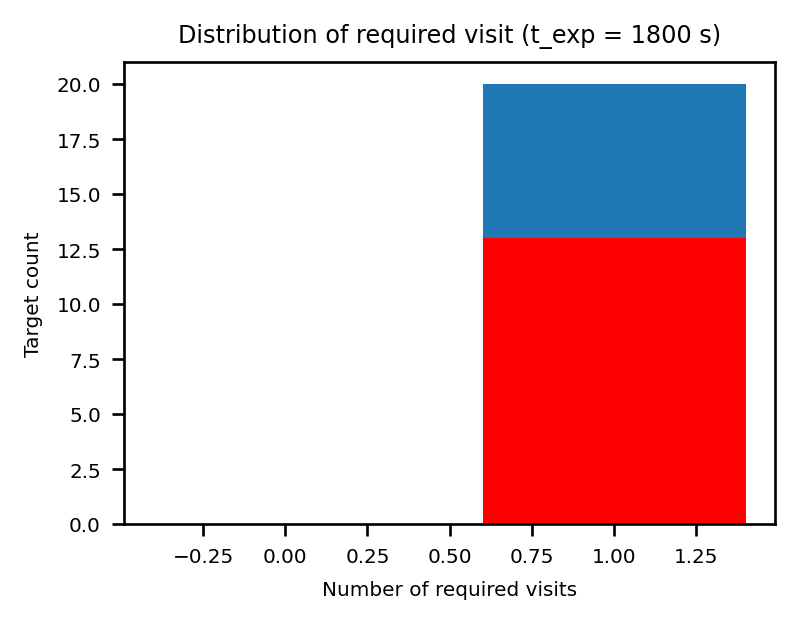

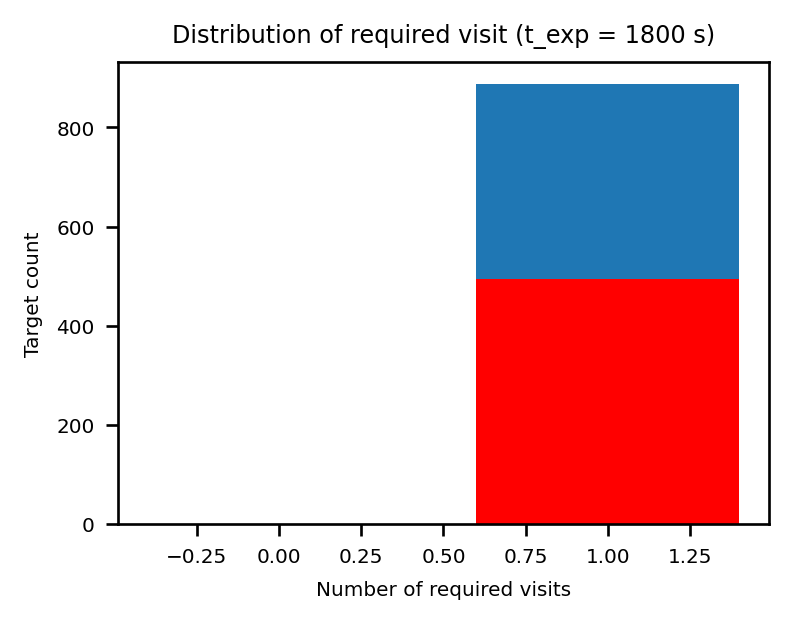

In [62]:
# Plot the distribution of required visits for each target list
exp_time = 1800 # seconds

for k in config.targets:
    if config.targets[k].prefix in ['sci']:
        f, ax = plt.subplots(1, 1, figsize=(3.5, 2.5), dpi=240)

        hist = np.bincount((np.ceil(target_lists[k].data['exp_time'] / exp_time)).astype(int))
        ax.bar(np.arange(hist.size), hist)

        print(k, 'all', hist)

        mask = target_lists[k].data['targetid'].isin(assignments[assignments['prefix'] == config.targets[k].prefix]['targetid'])
        hist = np.bincount((np.ceil(target_lists[k].data['exp_time'][mask] / exp_time)).astype(int))
        ax.bar(np.arange(hist.size), hist, color='r')

        print(k, 'assigned', hist)

        ax.set_title(f'Distribution of required visit (t_exp = {exp_time} s)')
        ax.set_xlabel('Number of required visits')
        ax.set_ylabel('Target count')
